# Training a Classification Model

One of our concerns while working with the data is that our regression model would simply "rediscover" the formula used by the WHR to generate the scores for each country. We have taken steps to correct this, which are better documented elsewhere, but we were also inspired to attempt to create a classification model. By creating a classification model and globbing the discrete scores given by the WHR into "bins" we remove the ability of the model to directly train on the score, preventing it from rediscovering WHR's formula (in theory), while still preserving the broad information of "happiness strata" (is this country more happy / will have a higher score than all the countries in this bin).

## Set Up

In [1]:
import pandas as pd
import numpy as np
from dataset import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import warnings
from itertools import combinations
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

## Loading the Data

In [2]:
df = get_consistent_yearly()

Rename the columns to be easier to work with.

In [3]:
old_cols = list(df.columns)
df[["country", "rank", "score", "gdp", "support", "expectancy", "freedom", "corruption", "generosity", "year"]] = df[df.columns]
old_cols.remove('year')
df = df.drop(columns=old_cols)

Verify that our renaming worked.

In [4]:
df.columns

Index(['year', 'country', 'rank', 'score', 'gdp', 'support', 'expectancy',
       'freedom', 'corruption', 'generosity'],
      dtype='object')

Manually seprate the features into categorical vs. numerical.

In [5]:
categorical = ["country", "rank", "year"]
numerical = list(set(df.columns)-set(categorical)-set(["score"])) # remove score as feature! We don't want to give the game away

Fix the european-style decimals in the dataset.

In [6]:
for col in numerical:
    df[col] = df[col].astype(str).str.replace(',','.')

Enforce proper data types.

In [7]:
df[categorical] = df[categorical].astype("category")
df[numerical] = df[numerical].astype("float64")

Normalize country names.

In [8]:
df["country"] = df["country"].str.replace("[^a-zA-Z]","").str.replace(' ','').str.lower().str.replace('hongkong.+','hongkong').str.replace('czechia','czechrepublic').str.replace('taiwan.+','taiwan').str.replace('northern','north').str.replace('kingdomof','')

/tmp/ipykernel_82367/65253218.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["country"] = df["country"].str.replace("[^a-zA-Z]","").str.replace(' ','').str.lower().str.replace('hongkong.+','hongkong').str.replace('czechia','czechrepublic').str.replace('taiwan.+','taiwan').str.replace('northern','north').str.replace('kingdomof','')


Perform outlier removal. We are very conservative with our removal procedure and only remove null values.

In [9]:
df = df.dropna()

## Binning our Data

We need to separate our data into bins. To start we create two basic bins: `happy` and `unhappy`. We split our data down the middle for each year. So the upper half for each year will be `happy` and the lower half will be `unhappy`.

In [10]:
bin_cols = []
for name, group in df.groupby('year'):
    middle = group['rank'].astype(int).max()//2
    bin_cols.append(df[df["year"].astype(int) == name]["rank"].astype(int) <= middle)

y = pd.concat(bin_cols,ignore_index=True)

## Train-Test Split

Generate the train test split that we will be using for evaluating our models. We need to implement our own train-test split because we have some countries which occur only once, and we want to stratify by country.

In [11]:
def train_test_split_country(df, cols, y, test_size=0.25):
    train_size = 1 - test_size
    unique_countries = df.country.unique()
    np.random.shuffle(unique_countries)
    train_countries = unique_countries[:int(unique_countries.shape[0] * train_size)]
    test_countries = unique_countries[int(unique_countries.shape[0] * (train_size)):]

    # make sets
    X_train = df[cols][df.country.isin(train_countries)]
    y_train = y[df.country.isin(train_countries).values]
    X_test = df[cols][df.country.isin(test_countries)]
    y_test = y[df.country.isin(test_countries).values]
    return X_train, X_test, y_train, y_test

In [12]:
train_X, test_X, train_y, test_y = train_test_split_country(df, numerical, y)

Check the shapes of our partitions.

In [13]:
train_X.shape

(914, 6)

In [14]:
test_X.shape

(315, 6)

## Building the Pipeline

We construct a pipeline for automatically evaluating an arbitrary model for classification.

In [15]:
def test_model(model, X, y, categorical=categorical, numerical=numerical, scoring='f1', return_model=False):
    steps = [("Impute", SimpleImputer()), ("Scale", StandardScaler())]
    numerical_pipeline = Pipeline(steps)

    transformer = ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical),
        ("numerical", numerical_pipeline, numerical)
    ])
    
    pipeline = Pipeline([("transform", transformer), ("model", model)])
    if not return_model:
        return cross_validate(pipeline, X=X, y=y, scoring=scoring, cv=5)
    else:
        return pipeline.fit(X,y)

## Training the Model on all Numerical Freatures

We define a collection of models which we want to evaluate performance for using our pipeline.

In [16]:
models = [
    ("baseline", DummyClassifier(strategy='constant',constant=True)),
    ("naive bayes gaussian", GaussianNB()),
    ("random forest", RandomForestClassifier()),
    ("MLP", MLPClassifier(max_iter=500))
]

We train our models using _ony_ the numerical features

In [17]:
for model_type, model in models:
    scores = test_model(model, train_X, train_y,categorical=[])['test_score']
    print(f'{model_type} achieved average f1 score of {np.average(scores)}')

baseline achieved average f1 score of 0.6214136542041209
naive bayes gaussian achieved average f1 score of 0.8429848655239134
random forest achieved average f1 score of 0.8251899128228594


/home/keysers/jupyter-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/keysers/jupyter-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/keysers/jupyter-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/keysers/jupyter-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP achieved average f1 score of 0.8187460660370878


/home/keysers/jupyter-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


The best model oscillates between MLPClassifier and random forest. We observed a slightly higher percentage of the time that MLPClassifier was actually better, so we picked MLPClassifier as the model to optimize for.

## Feature Selection

Do an exhaustive search over the feature space since we have a low number of total features. Note we set max_iter to 500 to stymie the warnings of the optimizer not converging.

In [18]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

best = ([],0.0)
for k in range(1,len(numerical)+1):
    for feature_set in combinations(numerical,k):
        scores = test_model(MLPClassifier(max_iter=500),
                            train_X,
                            train_y,
                            categorical=[],
                            numerical=feature_set)['test_score']
        avg_score = np.mean(scores)
        
        if avg_score > best[1]:
            best = (feature_set,avg_score)

feature_set = list(best[0])

In [19]:
print(feature_set)

['generosity', 'support', 'corruption', 'gdp', 'expectancy', 'freedom']


We run the best feature set ourselves to see what score it gets

In [20]:
scores = test_model(MLPClassifier(max_iter=500),
                    train_X,
                    train_y,
                    categorical=[],
                    numerical=feature_set)['test_score']
avg_score = np.mean(scores)
avg_score

0.8330792414361982

Finally, we evaluate our model on the testing set.

In [21]:
model = test_model(MLPClassifier(max_iter=500),
                   train_X,
                   train_y,
                   categorical=[],
                   numerical=feature_set,
                   return_model=True)
pred = model.predict(test_X[feature_set])
print('f1 score =',
      f1_score(test_y,pred,average=('binary' if test_y.nunique() == 2 else 'micro')),
      '\naccuracy =',
      accuracy_score(test_y,pred))

f1 score = 0.8363636363636363 
accuracy = 0.8


## Multiple Bins

Now that we've selected a model, we want to evaluate how it performs when we start putting each country into bins based on their rank. We decided on this binning approach because we had concerns that the model would just learn the formula used by the World Happiness Report if it was trained on predicting exact ranks. By globbing ranks together in ranges, we allow the model to learn how to rank the happiness of each country with some flexibility. We suspect that by binning our ranks, we will see the performance of the model go down.

In [22]:
from functools import reduce
def _bin(df,num_bins):
    bin_cols = []
    max_rank = df["rank"].astype(int).max()
    min_rank = df["rank"].astype(int).min()
    for bin_no, boundary in enumerate(np.flip(np.linspace(max_rank,min_rank,num_bins,endpoint=False))):
        labels = pd.Series([bin_no]*df["rank"].size)
        labels = labels.where(df["rank"].astype(int) <= boundary, None)
        bin_cols.append(labels)
        
    y = reduce(lambda acc,x: acc.combine_first(x), bin_cols, pd.Series([None]*df["rank"].size))
    return y.fillna(method='ffill')

We visualize what the size of each bin looks like in the range that we wish to test: [3,15]. Note that because of how we calculated the binning (by taking the linspace over the range with the number of cuts), we don't have completely even bins, but all bins are _relatively_ close to each other. If someone were to pick up this project after us, they may wish to consider different binning algorithms to see how that impacts the model.

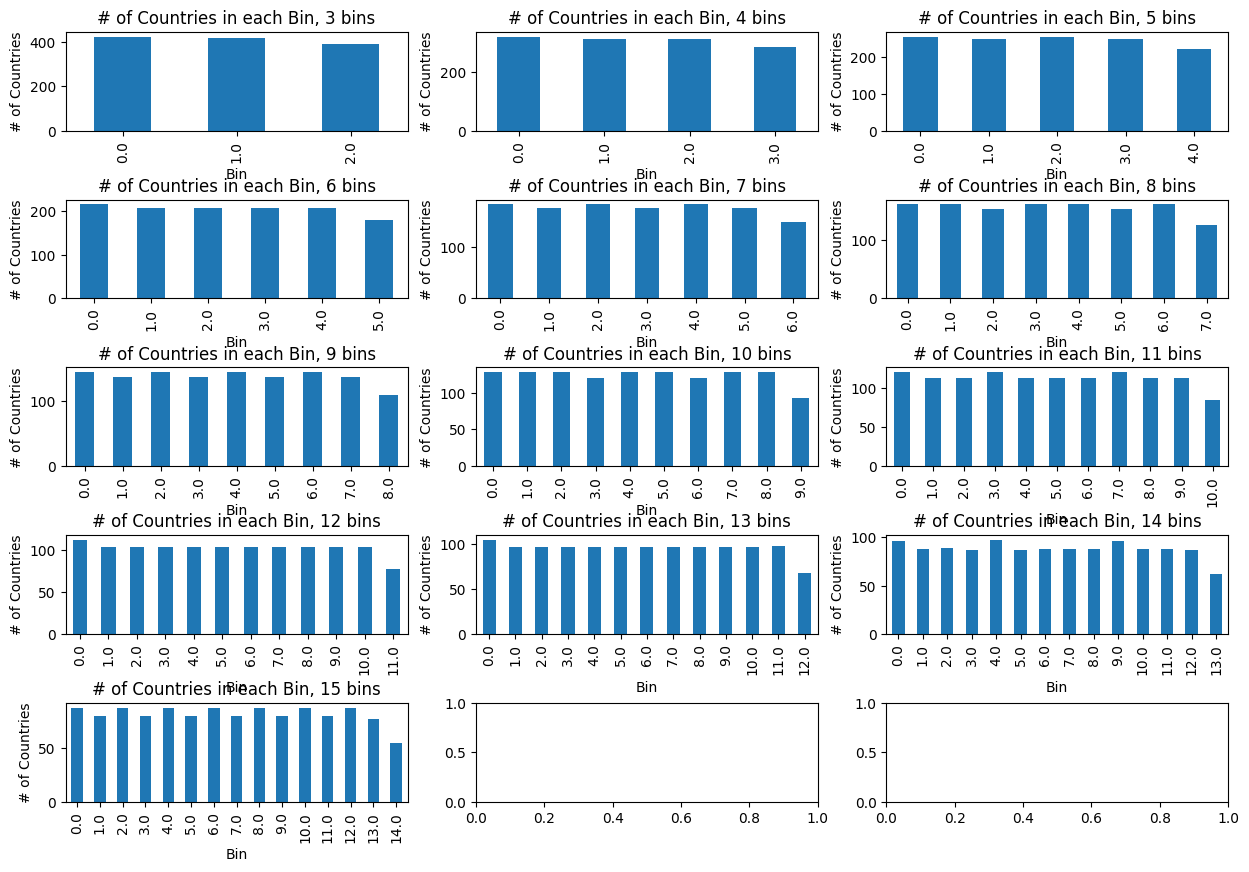

In [23]:
lower = 3
upper = 16

fig, axs = plt.subplots(5,3)
fig.set_size_inches(15,10)
plt.subplots_adjust(hspace=0.7)

for k, ax in zip(range(lower, upper),axs.ravel()):
    y = _bin(df,k)
    y.value_counts().sort_index().plot.bar(ax=ax)
    ax.set_title(f'# of Countries in each Bin, {k} bins')
    ax.set_ylabel('# of Countries')
    ax.set_xlabel('Bin')

In [24]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

for k in range(lower, upper):
    # train / test split
    bins = _bin(df,k)
    train_X, test_X, train_y, test_y = train_test_split(df,bins,stratify=bins)
    scores = test_model(MLPClassifier(max_iter=500),
                    train_X,
                    train_y,
                    categorical=[],
                    numerical=feature_set,
                    scoring='accuracy')['test_score']
    avg_score = np.mean(scores)
    print(f'{k} bins achieved average score of {avg_score}')

3 bins achieved average score of 0.7199294947121034
4 bins achieved average score of 0.6319447708578143
5 bins achieved average score of 0.5472326674500587
6 bins achieved average score of 0.4755405405405405
7 bins achieved average score of 0.45282608695652177
8 bins achieved average score of 0.4332197414806111
9 bins achieved average score of 0.39087544065804936
10 bins achieved average score of 0.3430787309048179
11 bins achieved average score of 0.32791421856639247
12 bins achieved average score of 0.31378378378378385
13 bins achieved average score of 0.28882491186839016
14 bins achieved average score of 0.27905992949471214
15 bins achieved average score of 0.2649471210340776


We select **5 bins** as our target, because it maps well with the common scale used in surveys. For example, _rate your happiness/pain/mood/etc on a scale of 1 to 5_.


Now that we have both selected a model and a number of bins we perform hyperparameter tuning for our model. We perform a random search over the hyperparamters.


Note we recompute our train/test split because now that we have a number of bins, we changed our target variable.

In [25]:
params = {
    'max_iter': randint(1024,2048),
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

bins = _bin(df,5)
train_X, test_X, train_y, test_y = train_test_split(df,bins,stratify=bins)
random_src = RandomizedSearchCV(estimator=MLPClassifier(),param_distributions=params)

random_src.fit(train_X[feature_set], train_y)

RandomizedSearchCV(estimator=MLPClassifier(),
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(10, 30, 10),
                                                               (20,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1230a9ab30>,
                                        'solver': ['sgd', 'adam']})

In [26]:
random_src.best_score_

0.5548883666274971

In [27]:
random_src.best_estimator_

MLPClassifier(hidden_layer_sizes=(20,), max_iter=1795)

In [28]:
random_src.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'constant',
 'max_iter': 1795,
 'solver': 'adam'}

### Evaluating on the Testing Set

Finally, we evalute our model on the testing set.

In [29]:
model = test_model(MLPClassifier(**random_src.best_params_),
                   train_X,
                   train_y,
                   categorical=[],
                   numerical=feature_set,
                   return_model=True)
pred = model.predict(test_X[feature_set])
print('f1 score =',
      f1_score(test_y,pred,average=('binary' if test_y.nunique() == 2 else 'micro')),
      '\naccuracy =',
      accuracy_score(test_y,pred))

f1 score = 0.5909090909090909 
accuracy = 0.5909090909090909
